In [1]:
%autosave 0

Autosave disabled


In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.cm as cm
from scipy.signal import lfilter
from scipy.optimize import curve_fit
from scipy import stats
from scipy.stats import logistic, circmean, vonmises, circstd 
import uncertainties as unc
from uncertainties import unumpy as unp
import random
import time
import intervals as I

In [3]:
def connectivity(n, modes):
    """Creates a (``n`` x ``n``) connectivity matrix for the ring neural field model.

    :param int n: number of rate neurons/population.
    :param collections.Iterable[float] modes: amplitude of the modes of connectivity ordered from 0 to n_modes.
    :return: connectivity matrix.
    :rtype: np.ndarray
    """
    
    [i_n, j_n] = np.meshgrid(range(n), range(n))
    ij = (i_n - j_n) * (2.0 * np.pi / n)

    jphi = 0
    for k, mode in enumerate(modes):
        if k == 0:
            jphi = mode
        else:
            jphi += 2.0 * mode * np.cos(k * ij)

    return jphi 

In [4]:
# Transfer function (scalar)

def sigmoid_pw(x, a=0.0000, **kwargs):
    """Piece-wise transfer function, scalar version.

    :param float x: input current
    :param float a: optional minimal firing rate (default = 0)
    :param kwargs: processed keyword arguments (``tau``, ``gamma``).
    :return: firing rate response.
    :rtype: float
    """
    
    if isinstance(x, (list, np.ndarray)):
        return sigmoid_pw_v(x, a, **kwargs)
    tau = kwargs.get('tau', 1.0)
    gamma = kwargs.get('gamma', 1.0)
    if x <= 0.0:
        return a * gamma / tau
    elif 0.0 < x < 1.0:
        return (a + x ** 2.0) * gamma / tau
    else:
        return (a + 2.0 * np.sqrt(x - 3.0 / 4.0)) * gamma / tau

In [5]:
# Transfer function (vectorial)

def sigmoid_pw_v(x, a=0.0000, **kwargs):
    """Piece-wise transfer function, vectorial version.
    
    :param np.ndarray of float x: input current
    :param float a: optional minimal firing rate (default = 0)
    :param kwargs: processed keyword arguments (``tau``, ``gamma``).
    :return: firing rate response.
    :rtype: np.ndarray of float
    """
    
    if not isinstance(x, (list, np.ndarray)):
        return sigmoid_pw(float(x), a, **kwargs)
    tau = kwargs.get('tau', 1.0)
    gamma = kwargs.get('gamma', 1.0)
    phi = x * 1.0
    # Conditions:
    m1 = (x <= 0.0)
    m3 = (x >= 1.0)
    m2 = ~(m1 | m3)
    # Function
    phi[m1] = a
    phi[m2] = a + x[m2] ** 2
    phi[m3] = a + 2.0 * np.sqrt(x[m3] - 3.0 / 4.0)

    return phi * gamma / tau 

In [6]:
def ou_process(dt, nsteps, mu, sigma, tau, trials=1, n_spatial=1, seed=None):
    """ Generates an approximation of a single (or trials) Ornstein-Uhlenbeck process(es)
        for a single (oumodes) units.

    :param float dt: integration time-step.
    :param int nsteps: number of time steps.
    :param float mu: offset of the processs.
    :param float sigma: standard deviation of the process.
    :param float tau: time scale of the process (< dt).
    :param int trials: number of processes to be generated (trials).
    :param int n_spatial: number of spatially distributed units or modes of Fourier.
    :param int or None seed: seed for the random number generator.
    :return: time series: array (nsteps x trials x oumodes).
    :rtype: np.ndarray
    """
    
    # Constants
    a = np.exp(-dt / tau)
    b = mu * (1.0 - a)
    c = sigma * np.sqrt(1.0 - a ** 2)

    if seed is not None:
        np.random.seed(seed)

    s = lfilter(np.ones(1), [1, -a], b + c * np.random.randn(nsteps, trials, n_spatial), axis=0)
    return s

In [7]:
def compute_phase(x, n, c=(0.0,), s=(0.0,), wavenumber=1):
    """ Function that gives an approximate value of the phase of a spatial profile by projecting the vector x
    into a cosine function.

    :param Cython.Includes.numpy.ndarray x: firing rates matrix (or vector) with shape (d1, d2, ..., n).
    :param int n: spatial dimension (spatial discretization).
    :param np.ndarray of float c: cosine function, precompute it for faster computation.
    :param np.ndarray of float s: sine function, precompute it for faster computation.
    :param int wavenumber: wavenumber of the corresponding phase that we want to compute.
    :rtype: np.ndarray of float
    """

    # Check external cosine and sine functions
    if len(c) != n or len(s) != n:
        c = np.cos(np.arange(n) * wavenumber * 2.0 * np.pi / n - np.pi)
        s = np.sin(np.arange(n) * wavenumber * 2.0 * np.pi / n - np.pi)

    # norm of sine and cosine functions depends on n (discretization of the space)
    return np.arctan2((np.dot(x, s) / (n / 2.0) ** 2), (np.dot(x, c) / (n / 2.0) ** 2))

In [8]:
def equalbins(x, nbins):
    """ Computes the binning vector of a given data vector `x` categorized in equal proportion in `nbins`.

    :param np.ndarray x: vector of data to be binned.
    :param int nbins: number of bins.
    :return: a vector with the bins corresponding to each data point.
    :rtype: np.ndarray
    """
    
    quantiles = np.quantile(x, np.arange(1, nbins) / nbins)
    edges = np.concatenate(([-np.inf], quantiles, [np.inf]))
    return np.digitize(x, edges)

In [9]:
def compute_estimation(dataframe, nbins=41, xlabel='theta', ylabel='theta_est', **kwargs):
    """ Computes the estimation curve given an angular binning with `nbins` bins.
    
    :param pd.DataFrame dataframe: data-frame containing the circular mean of the stimulus orientation along with
                                   its estimation by the model.
    :param int nbins: number of bins to divide the angular range and perform the average across trials.
    :param str ylabel: label of the outcome column in the data-frame.
    :param kwargs: additional keyword arguments.
    :return: Returns a tuple (binning: average stimulus orientation, average estimation, standard error).
    :rtype: (pd.Series, pd.Series, pd.Series)
    """
    
    lim = kwargs.pop('lim', np.pi/2)
    # We define the categories for the data points and the model points/line
    dataframe['bin'] = equalbins(dataframe[xlabel], nbins)
    # Group the data by the binning and compute the circular mean of the stimulus orientation averages and the 
    # circular mean of the estimated average orientations
    gby_bin = dataframe.groupby('bin')
    x_avg = gby_bin[xlabel].apply(circmean, low=-np.pi, high=np.pi)
    y_avg = gby_bin[ylabel].apply(circmean, low=-np.pi, high=np.pi)
    y_std = gby_bin[ylabel].apply(circstd, low=-np.pi, high=np.pi)
    # Select the data inside the desired range
    s_x = x_avg.loc[np.abs(x_avg) <= lim]
    s_y = y_avg.loc[np.abs(x_avg) <= lim]
    s_e = y_std.loc[np.abs(x_avg) <= lim]
    return s_x, s_y, s_e

## Single trial

In [10]:
start = time.time()
# Define some variables

tstim = 2.05
nstim = 1
tmax = nstim * tstim  # Maximum time
dt = 2E-4  # Time step
tau = 20E-3  # Neurons' time constant
n = 200 # Number of neurons in the ring structure

tpoints = np.arange(0, tmax, dt)
theta = np.arange(n) / n * (2 * np.pi) - np.pi
rsteps = len(tpoints)
ntrials = 1

r = np.ones((rsteps, n)) * 0.1

i0 = 1.1 # Increase this to obtain the bump (supercritical bump, it grows as sqrt(i0), and its dynamics are very slow near i0 = 1)
theta_stim = 60 * np.pi / 180 # direcció angular del estímul

i_stim = 5E-3 * np.cos(theta - theta_stim)

#modes = [-1.0, 2.0, 0.2]
modes = [-2.0, 1.0, 0.5]
cnt = connectivity(n, modes)

mu, sigmaou, tau_ou = 0, 0.15, 1E-3
ou = ou_process(dt, rsteps, 0.0, sigmaou, tau_ou, ntrials, n)  # (stim_steps, ntrials, n), seed=None
#ou = np.zeros_like(ou)

# Loop
tstep = 0    
temps = 0.0
ttau = dt / tau

while temps < (tmax - dt):

    # Time step variables
    kp = tstep % rsteps #kp is the 0 step
    k = (tstep + rsteps - 1) % rsteps #k is the -1 step
    
    # 2. Presynaptic inputs
    s = 1.0 / n * np.dot(r[k], cnt)

    if temps >= tmax/2:
        i_stim = i_stim*0.0
    #3. Integration
    try:
        r[kp] = r[k] + ttau * (-r[k] + sigmoid_pw_v(i0 + i_stim + tau * s + ou[kp], tau=tau)) 
    except FloatingPointError:  # Prevent UnderFlow errors by setting the firing rate to 0.0
        r[r < 1E-12] = 0.0
    tstep += 1
    temps = tstep * dt
r[-1] = r[-2] 

phase = compute_phase(r, n)[-1]

end = time.time()
print("Real stimulus direction:", theta_stim * 180 / np.pi % 360)
print("Phase of the bump:", phase * 180 / np.pi % 360)
print("Time elapsed:", end - start)

Real stimulus direction: 59.99999999999999
Phase of the bump: 53.05466789041914
Time elapsed: 0.5631680488586426


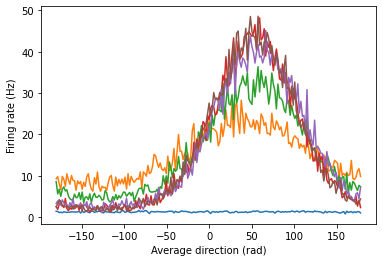

In [11]:
for i in [1, 2000, 3000, 5000, 8000, -1]:
    plt.plot(theta * 180/np.pi, r[i])
plt.xlabel('Average direction (rad)')
plt.ylabel('Firing rate (Hz)')
plt.show()

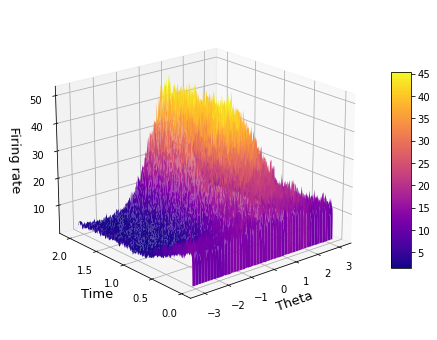

In [12]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')

x = theta
y = tpoints
X,Y = np.meshgrid(x,y)
Z = r

surf1 = ax.plot_surface(X, Y, Z, cmap='plasma')

ax.view_init(20, 230)
#ax.set_title('Bump creation', fontsize=18)
ax.set_xlabel('Theta', fontsize=13)
ax.set_ylabel('Time', fontsize=13)
ax.set_zlabel('Firing rate' , fontsize=13, rotation=0)
ax.zaxis.set_label_coords(40, -10.025)

fig.colorbar(surf1, ax=ax, shrink=0.6, aspect=10)

plt.show()

## Arbitrary number of trials

In [392]:
df = pd.DataFrame(columns=['theta', 'theta_est'])
df

,theta,theta_est


In [393]:
start = time.time()
# Define some variables

tstim = 0.55
nstim = 1
tmax = nstim * tstim  # Maximum time
dt = 2E-4  # Time step
tau = 20E-3  # Neurons' time constant
n = 200 # Number of neurons in the ring structure

tpoints = np.arange(0, tmax, dt)
theta = np.arange(n) / n * (2 * np.pi) - np.pi
rsteps = len(tpoints)
ntrials = 50

i0 = 2  # Increase this to obtain the bump (supercritical bump, it grows as sqrt(i0), and its dynamics are very slow near i0 = 1)

#modes = [-1.0, 2.0, 0.2]
modes = [-2.0, 1.0, 0.5]
cnt = connectivity(n, modes)
dec_mode = 1

for i in range(100):
    r = np.ones((rsteps, ntrials, n)) * 0.1
    theta_stim = np.random.uniform(-60 * np.pi / 180, 60 * np.pi / 180, ntrials) # angular direction of stimulus
    Theta, Theta_stim = np.meshgrid(theta, theta_stim)
    i_stim = 5E-3 * np.cos(Theta - Theta_stim)

    mu, sigmaou, tau_ou = 0, 0.15, 1E-3
    ou = ou_process(dt, rsteps, 0.0, sigmaou, tau_ou, ntrials, n)  # (stim_steps, ntrials, n) seed=None
    
    # Loop
    tstep = 0    
    temps = 0.0
    ttau = dt / tau

    while temps < (tmax - dt):

        # Time step variables
        kp = tstep % rsteps # kp is the 0 step
        k = (tstep + rsteps - 1) % rsteps # k is the -1 step

        # 2. Presynaptic inputs
        s = 1.0 / n * np.dot(r[k], cnt)

        #if temps >= tmax/2:
         #   i_stim = i_stim*0.0
            
        # 3. Integration
        try:
            r[kp] = r[k] + ttau * (-r[k] + sigmoid_pw_v(i0 + i_stim + tau * s + ou[kp], tau=tau)) 
        except FloatingPointError:  # Prevent UnderFlow errors by setting the firing rate to 0.0
            r[r < 1E-12] = 0.0
        tstep += 1
        temps = tstep * dt
    r[-1] = r[-2] + ttau * (-r[-2] + sigmoid_pw_v(i0 + i_stim + tau * s + ou[-1], tau=tau))
            
    if dec_mode == 1: 
        
        # Reset some variables
        tmax = 2.55
        temps = 0.0

        i_stim = 5E-3 * np.cos(2*(Theta - np.pi/2))
        #i_stim = 5E-3 * abs(np.cos(theta))
        
        while temps < (tmax - dt):

            # Time step variables
            kp = tstep % rsteps #kp is the 0 step
            k = (tstep + rsteps - 1) % rsteps #k is the -1 step

            # 2. Presynaptic inputs
            s = 1.0 / n * np.dot(r[k], cnt)

            # 3. Integration
            try:
                r[kp] = r[k] + ttau * (-r[k] + sigmoid_pw_v(i0 + i_stim + tau * s + ou[kp], tau=tau)) 
            except FloatingPointError:  # Prevent UnderFlow errors by setting the firing rate to 0.0
                r[r < 1E-12] = 0.0
            tstep += 1
            temps = tstep * dt
        r[-1] = r[-2] + ttau * (-r[-2] + sigmoid_pw_v(i0 + i_stim + tau * s + ou[-1], tau=tau))

    phase = compute_phase(r, n)[-1]
    df = pd.concat([df, pd.DataFrame({'theta':theta_stim, 'theta_est': phase})], axis=0, levels=None, ignore_index=True)
    if i % 2 == 0: print(i)
    
end = time.time()
print("Time elapsed:", end - start)

0
2
4
6
8
10
12
14
16
18
20
22
24
26
28
30
32
34
36
38
40
42
44
46
48
50
52
54
56
58
60
62
64
66
68
70
72
74
76
78
80
82
84
86
88
90
92
94
96
98
Time elapsed: 11449.232129096985


In [394]:
# Edit DataFrame 

conditions = [
    (df['theta_est'] >= 0),
    (df['theta_est'] < 0)]
values = ['CW', 'CCW']
df['choice'] = np.select(conditions, values)

conditions = [
    (df['choice'] == 'CW'),
    (df['choice'] == 'CCW')]
values = [1, 0]

df['binary'] = np.select(conditions, values)

sx, sy, ss = compute_estimation(df, nbins=41)
[sx, sy, ss] = [np.rad2deg(k) for k in [sx, sy, ss]]

df

,theta,theta_est,choice,binary,bin
0,0.574994,1.355732,CW,1,33
1,0.498455,0.923603,CW,1,31
2,0.486924,0.959832,CW,1,31
3,-0.457787,-1.020369,CCW,0,13
4,0.435771,-0.905714,CCW,0,30
...,...,...,...,...,...
4995,-0.646842,-0.261371,CCW,0,9
4996,-0.324487,-0.151326,CCW,0,15
4997,-0.882871,-0.925085,CCW,0,4
4998,-0.342120,-0.331206,CCW,0,15


In [395]:
# Group DataFrame by intervals of theta 

df2 = pd.DataFrame({'theta': theta, 
                    'theta_est': df.groupby(pd.cut(df['theta'], np.append(theta, [np.pi])))['theta_est'].
                    apply(circmean, low=-np.pi, high=np.pi),
                    'std' : df.groupby(pd.cut(df['theta'], np.append(theta, [np.pi])))['theta_est'].
                    apply(circstd, low=-np.pi, high=np.pi).fillna(0)
                   })
df2['mult'] = df.groupby(pd.cut(df['theta'], np.append(theta, [np.pi]))).size().fillna(0).values
df2['prob'] = df.groupby(pd.cut(df['theta'], np.append(theta, [np.pi]))).mean().fillna(0).values[:,2]

df2.loc[np.abs(df2['theta']) < np.pi/3]

,theta,theta_est,std,mult,prob
theta,,,,,
"(-1.037, -1.005]",-1.036726,-0.974390,0.462885,100,0.040000
"(-1.005, -0.974]",-1.005310,-0.970578,0.490484,59,0.033898
"(-0.974, -0.942]",-0.973894,-0.929513,0.465363,69,0.028986
"(-0.942, -0.911]",-0.942478,-0.939580,0.453216,68,0.029412
"(-0.911, -0.88]",-0.911062,-0.901999,0.473728,82,0.048780
...,...,...,...,...,...
"(0.911, 0.942]",0.911062,0.807119,0.437042,76,0.973684
"(0.942, 0.974]",0.942478,0.908043,0.411023,63,1.000000
"(0.974, 1.005]",0.973894,0.975177,0.488716,77,0.948052


In [396]:
ivals = df2[np.abs(df2['theta']) < np.pi/3].index.to_numpy()
df3 = pd.DataFrame(index=ivals, columns=ivals).fillna(0)
for i in df.index:
    df3.loc[df3.index.values.contains(df.loc[i,'theta']), df3.index.values.contains(df.loc[i, 'theta_est'])] += 1
#df3 = df3 / df2.loc[np.abs(df2['theta']) < np.pi/3, 'mult'].values
df3 = df3 / len(df.index)
df3 = df3.sort_index(axis=0, ascending=False)

df3

,"(-1.037, -1.005]","(-1.005, -0.974]","(-0.974, -0.942]","(-0.942, -0.911]","(-0.911, -0.88]","(-0.88, -0.848]","(-0.848, -0.817]","(-0.817, -0.785]","(-0.785, -0.754]","(-0.754, -0.723]",...,"(0.754, 0.785]","(0.785, 0.817]","(0.817, 0.848]","(0.848, 0.88]","(0.88, 0.911]","(0.911, 0.942]","(0.942, 0.974]","(0.974, 1.005]","(1.005, 1.037]","(1.037, 1.068]"
"(1.037, 1.068]",0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0002,0.0000,0.0002,0.0002,0.0002,0.0002,0.0002,0.0004
"(1.005, 1.037]",0.0000,0.0000,0.0000,0.0000,0.0002,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0002,0.0002,0.0004,0.0008,0.0002,0.0004,0.0004,0.0008
"(0.974, 1.005]",0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0002,0.0008,0.0004,0.0004,0.0004,0.0008,0.0010,0.0000,0.0010,0.0008
"(0.942, 0.974]",0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0006,0.0006,0.0006,0.0000,0.0006,0.0002,0.0010,0.0000,0.0004,0.0000
"(0.911, 0.942]",0.0000,0.0000,0.0000,0.0000,0.0002,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0010,0.0002,0.0004,0.0002,0.0002,0.0006,0.0002,0.0004,0.0002,0.0004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(-0.911, -0.88]",0.0004,0.0004,0.0008,0.0006,0.0004,0.0000,0.0004,0.0002,0.0006,0.0004,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
"(-0.942, -0.911]",0.0006,0.0004,0.0004,0.0004,0.0006,0.0004,0.0004,0.0004,0.0002,0.0008,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
"(-0.974, -0.942]",0.0002,0.0000,0.0008,0.0008,0.0002,0.0006,0.0008,0.0004,0.0006,0.0006,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
"(-1.005, -0.974]",0.0004,0.0006,0.0004,0.0002,0.0004,0.0004,0.0004,0.0002,0.0006,0.0004,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0002,0.0000,0.0000,0.0000


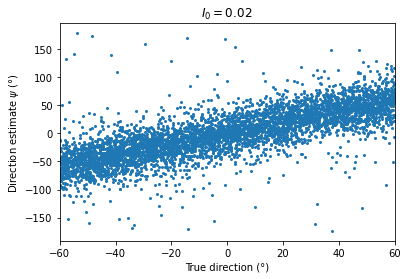

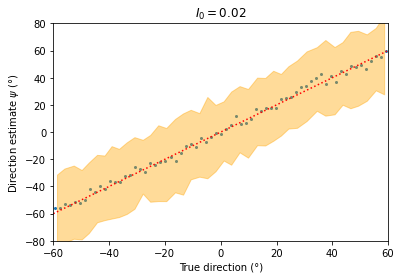

In [397]:
x = df.loc[:,'theta'].values * 180 / np.pi
y = df.loc[:,'theta_est'].values * 180 / np.pi
plt.scatter(x, y, s=4)
plt.xlim([-60, 60])
plt.title("$I_0=0.02$")
plt.xlabel("True direction (\N{DEGREE SIGN})")
plt.ylabel("Direction estimate $\psi$ (\N{DEGREE SIGN})")
plt.show()

# Estimació vs. average direction (circular mean)
x = df2.loc[:,'theta'].values * 180 / np.pi
y = df2.loc[:,'theta_est'].values * 180 / np.pi

plt.scatter(x, y, s=4)

# uncertainty lines (95% confidence)
plt.fill_between(sx, sy + ss, sy - ss, color='orange', alpha=0.4)

x1 = np.linspace(-60, 60, 100); y1 = x1
plt.axis([-60, 60, -80, 80])
plt.title("$I_0=0.02$")
plt.xlabel("True direction (\N{DEGREE SIGN})")
plt.ylabel("Direction estimate $\psi$ (\N{DEGREE SIGN})")
plt.plot(x1, y1, ':r')
plt.show()

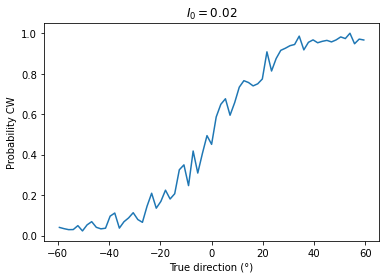

In [398]:
x = df2.loc[:,['theta']].values[np.abs(df2.loc[:,'theta'].values) < 60*np.pi/180][:,0] * 180 / np.pi
y = df2.loc[:,['prob']].values[np.abs(df2.loc[:,'theta'].values) < 60*np.pi/180][:,0]
plt.plot(x, y);
plt.title("$I_0=0.02$")
plt.xlabel("True direction (\N{DEGREE SIGN})")
plt.ylabel("Probability CW")
plt.show()

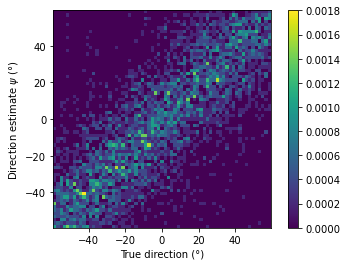

In [399]:
axis = df2.loc[np.abs(df2['theta']) <= np.pi/3, 'theta'].values * 180 / np.pi
plt.imshow(df3, extent = [min(axis), max(axis), min(axis), max(axis)])
plt.colorbar() 
plt.xlabel("True direction (\N{DEGREE SIGN})")
plt.ylabel("Direction estimate $\psi$ (\N{DEGREE SIGN})")
plt.show()

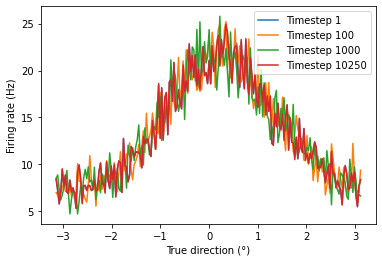

In [366]:
for i in [1, 100, 2500, -1]:
    plt.plot(theta, r[i, 0])
plt.legend(["Timestep 1", "Timestep 100", "Timestep 1000", "Timestep 10250"], loc ="upper right")
plt.xlabel("True direction (\N{DEGREE SIGN})")
plt.ylabel('Firing rate (Hz)')
plt.show()

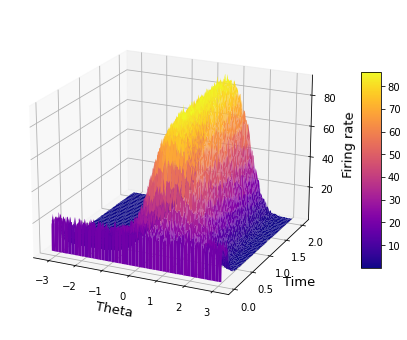

In [347]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')

x = theta
y = tpoints
X,Y = np.meshgrid(x,y)
Z = r[:,0,:]

#ax.set_title('Bump creation', fontsize=18)
    
surf1 = ax.plot_surface(X, Y, Z, cmap='plasma')

ax.view_init(20, 295)
ax.set_xlabel('Theta', fontsize=13)
ax.set_ylabel('Time', fontsize=13)
ax.set_zlabel('Firing rate' , fontsize=13, rotation=0)
ax.zaxis.set_label_coords(40, -10.025)

fig.colorbar(surf1, ax=ax, shrink=0.6, aspect=10)

plt.show()